#### Video Data
- AVI video data using UCF101 human action dataset
- Load data from zip file
- Read frame sequences from video
- Visualize video data
- Wrap the frame-generator with `tf.data.Dataset`

In [1]:
import tqdm ,random, pathlib, itertools, collections

import os
import cv2
import numpy as np
import remotezip as rz
import tensorflow as tf

import imageio
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed

2023-12-18 07:38:34.834850: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-18 07:38:34.870861: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-18 07:38:34.870933: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-18 07:38:34.872000: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-18 07:38:34.879214: I tensorflow/core/platform/cpu_feature_guar

In [4]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'

def list_files_from_zip_url(zip_url):
    files = []
    with rz.RemoteZip(zip_url) as zip:
        for zip_info in zip.infolist():
            files.append(zip_info.filename)
    return files

files = list_files_from_zip_url(URL)
files = [f for f in files if f.endswith('.avi')]
print(len(files))
files[:10]

13320


['UCF101/v_ApplyEyeMakeup_g01_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c04.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c05.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c06.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c04.avi']

#### UCF 101 dataset
- Contains 101 classes
- Only a subset will be used

In [5]:
def get_class(fname):
    return fname.split('_')[-3]

def get_files_per_class(files):
    files_for_class = collections.defaultdict(list)
    for fname in files:
        class_name = get_class(fname)
        files_for_class[class_name].append(fname)
    return files_for_class

In [10]:
# Total data
files_for_class = get_files_per_class(files)
classes = list(files_for_class.keys())

print('Num classes:', len(classes))
for i in range(10):
    print('Num videos for class[{i}]:', len(files_for_class[classes[i]]))

Num classes: 101
Num videos for class[{i}]: 145
Num videos for class[{i}]: 114
Num videos for class[{i}]: 145
Num videos for class[{i}]: 132
Num videos for class[{i}]: 108
Num videos for class[{i}]: 155
Num videos for class[{i}]: 150
Num videos for class[{i}]: 131
Num videos for class[{i}]: 134
Num videos for class[{i}]: 160


In [11]:
# We only want a subset of the 101 classes and only a limited number of videos for each class
def select_subset_of_classes(files_for_class, classes, files_per_class):
    files_subset = dict()

    for class_name in classes:
        class_files = files_for_class[class_name]
        files_subset[class_name] = class_files[:files_per_class]
    
    return files_subset

NUM_CLASSES = 10
FILES_PER_CLASS = 50

In [12]:
files_subset = select_subset_of_classes(files_for_class, classes[:NUM_CLASSES], FILES_PER_CLASS)
list(files_subset.keys())

['ApplyEyeMakeup',
 'ApplyLipstick',
 'Archery',
 'BabyCrawling',
 'BalanceBeam',
 'BandMarching',
 'BaseballPitch',
 'BasketballDunk',
 'Basketball',
 'BenchPress']

In [16]:
def download_from_zip(zip_url, to_dir, file_names): # Download contents of the zip file from the zip URL 
    with rz.RemoteZip(zip_url) as zip:
        for fn in tqdm.tqdm(file_names):
            class_name = get_class(fn)
            zip.extract(fn, str(to_dir/class_name))
            unzipped_file = to_dir/class_name/fn

            fn = pathlib.Path(fn).parts[-1]
            output_file = to_dir/class_name/fn
            unzipped_file.rename(output_file)

def split_class_lists(files_for_class, count):
    split_files = []
    remainder = {}
    for cls in files_for_class:
        split_files.extend(files_for_class[cls][:count])
        remainder[cls] = files_for_class[cls][count:]
    return split_files, remainder

In [17]:
def download_ucf_101_subset(zip_url, num_classes, splits, download_dir):
    files = list_files_from_zip_url(zip_url)
    for f in files:
        path = os.path.normpath(f)
        tokens = path.split(os.sep)
        if len(tokens) <= 2:
            files.remove(f) # Remove that item from the list if it does not have a filename
    
    files_for_class = get_files_per_class(files)
    classes = list(files_for_class.keys())[:num_classes]

    for cls in classes:
        random.shuffle(files_for_class[cls])
    
    files_for_class = {x: files_for_class[x] for x in classes}

    dirs = {}
    for split_name, split_count in splits.items():
        print(split_name, ':')
        split_dir = download_dir/split_name
        split_files, files_for_class = split_class_lists(files_for_class, split_count)
        download_from_zip(zip_url, split_dir, split_files)
        dirs[split_name] = split_dir
    
    return dirs


In [18]:
download_dir = pathlib.Path('../data/UCF101_subset/')
subset_paths = download_ucf_101_subset(URL,
                                       num_classes=NUM_CLASSES,
                                       splits = {'train':30, 'val':10, 'test':10},
                                       download_dir=download_dir)

train :


100%|██████████| 300/300 [03:13<00:00,  1.55it/s]


val :


100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


test :


100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


In [19]:
video_count_train = len(list(download_dir.glob('train/*/*.avi')))
video_count_val = len(list(download_dir.glob('val/*/*.avi')))
video_count_test = len(list(download_dir.glob('test/*/*.avi')))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 500


#### Create frames from each video file

In [36]:
def format_frames(frame, output_size): # Pad and resize an image from a video
    frame = tf.image.convert_image_dtype(frame, tf.float32)
    frame = tf.image.resize_with_pad(frame, *output_size)
    return frame

def frames_from_video_file(video_path, n_frames, output_size=(224,224), frame_step=15): # Create frames from video
    # Read the frames from each video
    result = []
    src = cv2.VideoCapture(str(video_path))
    video_length = src.get(cv2.CAP_PROP_FRAME_COUNT) # I assume this counts the number of frames
    need_length = 1+ (n_frames-1) * frame_step # The frames you need
    if need_length > video_length:
        start = 0
    else:
        max_start = video_length-need_length
        start = random.randint(0, max_start+1) # Get starting frame
    
    src.set(cv2.CAP_PROP_POS_FRAMES, start) # Set starting frame
    ret, frame = src.read()
    result.append(format_frames(frame, output_size))
    for _ in range(n_frames-1):
        for _ in range(frame_step):
            ret, frame = src.read()
        if ret:
            result.append(format_frames(frame, output_size))
        else:
            result.append(np.zeros_like(result[0]))
    src.release()
    result = np.array(result)[..., [2,1,0]]
    return result

In [26]:
# Use on new video
!curl -O https://upload.wikimedia.org/wikipedia/commons/8/86/End_of_a_jam.ogv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 55.0M  100 55.0M    0     0  22.6M      0  0:00:02  0:00:02 --:--:-- 22.6M


In [37]:
video_path = 'End_of_a_jam.ogv'
sample_video = frames_from_video_file(video_path, n_frames=10)
sample_video.shape

(10, 224, 224, 3)

#### Visualize Video Data


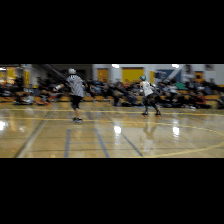

In [47]:
def to_gif(images):
    converted_images = np.clip(images*255, 0, 255).astype(np.uint8)
    imageio.mimsave('../data/animation.gif', converted_images, fps=10)
    return embed.embed_file('../data/animation.gif')
to_gif(sample_video)


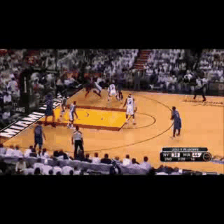

In [53]:
ucf_sample_video = frames_from_video_file(next(subset_paths['train'].glob('*/*.avi')), 50)
to_gif(ucf_sample_video)

In [54]:
# Define FrameGenerator class to add to TF data pipeline
class FrameGenerator:
    def __init__(self, path, n_frames, training=False):
        # Returns a set of frames with their associated label

        self.path = path
        self.n_frames = n_frames
        self.training = training
        self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
        self.class_ids_for_name = dict((name, idx) for idx,name in enumerate(self.class_names))
    
    def get_files_and_class_names(self):
        video_paths = list(self.path.glob('*/*.avi'))
        classes = [p.parent.name for p in video_paths]
        return video_paths, classes
    
    def __call__(self):
        video_paths, classes = self.get_files_and_class_names()
        pairs = list(zip(video_paths, classes))

        if self.training:
            random.shuffle(pairs)
        
        for path, name in pairs:
            video_frames = frames_from_video_file(path, self.n_frames)
            label = self.class_ids_for_name[name] # Label Encodings
            yield video_frames, label

In [55]:
fg = FrameGenerator(subset_paths['train'], 10, training=True)
frames,label = next(fg())
print(f"Shape: {frames.shape}")
print(f"Label: {label}")

Shape: (10, 224, 224, 3)
Label: 5


In [56]:
# TF input pipeline

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype=tf.float32),
                    tf.TensorSpec(shape=(), dtype = tf.int16))
train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], 10, training=True),
                                          output_signature=output_signature)

In [57]:
for frames, labels in train_ds.take(10):
  print(labels)

tf.Tensor(5, shape=(), dtype=int16)
tf.Tensor(2, shape=(), dtype=int16)
tf.Tensor(4, shape=(), dtype=int16)
tf.Tensor(7, shape=(), dtype=int16)
tf.Tensor(3, shape=(), dtype=int16)
tf.Tensor(2, shape=(), dtype=int16)
tf.Tensor(2, shape=(), dtype=int16)
tf.Tensor(7, shape=(), dtype=int16)
tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(0, shape=(), dtype=int16)


In [58]:
val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], 10),
                                        output_signature = output_signature)

In [59]:
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of training set of frames: (10, 224, 224, 3)
Shape of training labels: ()
Shape of validation set of frames: (10, 224, 224, 3)
Shape of validation labels: ()


#### Modelling
- Use Pretrained `EfficientNetB0`

In [60]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

train_ds = train_ds.batch(2)
val_ds = val_ds.batch(2)

train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

2023-12-18 11:16:37.500276: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:12: Filling up shuffle buffer (this may take a while): 108 of 1000
2023-12-18 11:16:56.370714: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


Shape of training set of frames: (2, 10, 224, 224, 3)
Shape of training labels: (2,)


2023-12-18 11:17:06.450019: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 80 of 1000


Shape of validation set of frames: (2, 10, 224, 224, 3)
Shape of validation labels: (2,)


2023-12-18 11:17:08.937291: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


In [62]:
from keras import Sequential
from keras.layers import Rescaling, TimeDistributed, Dense, GlobalAveragePooling3D

net = tf.keras.applications.EfficientNetB0(include_top=False)
net.trainable=False

model = tf.keras.Sequential([
    Rescaling(scale=255),
    TimeDistributed(net), # Applies the net model to each frame of the video allowing the use of a 2D CNN instead of a more expensive 3D CNN
    Dense(10),
    GlobalAveragePooling3D()
])

model.compile(optimizer = 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

model.fit(train_ds, 
          epochs = 10,
          validation_data = val_ds,
          callbacks = tf.keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss'))

Epoch 1/10


2023-12-18 11:33:58.793973: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-18 11:33:59.068558: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-18 11:34:00.436950: I external/local_xla/xla/service/service.cc:168] XLA service 0xd0038b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-18 11:34:00.436992: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti Laptop GPU, Compute Capability 8.6
2023-12-18 11:34:00.463159: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1702928040.584033 1700252 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


150/150 [==============================] - 18s 59ms/step - loss: 1.1581 - accuracy: 0.7133 - val_loss: 0.4839 - val_accuracy: 0.9600
Epoch 2/10
150/150 [==============================] - 6s 43ms/step - loss: 0.3281 - accuracy: 0.9667 - val_loss: 0.2760 - val_accuracy: 0.9700
Epoch 3/10
150/150 [==============================] - 7s 44ms/step - loss: 0.1814 - accuracy: 0.9900 - val_loss: 0.2058 - val_accuracy: 0.9800
Epoch 4/10
150/150 [==============================] - 7s 44ms/step - loss: 0.1206 - accuracy: 0.9933 - val_loss: 0.1556 - val_accuracy: 0.9900
Epoch 5/10
150/150 [==============================] - 6s 43ms/step - loss: 0.0868 - accuracy: 0.9967 - val_loss: 0.1337 - val_accuracy: 0.9900
Epoch 6/10
150/150 [==============================] - 7s 45ms/step - loss: 0.0698 - accuracy: 0.9967 - val_loss: 0.1188 - val_accuracy: 0.9900
Epoch 7/10
150/150 [==============================] - 7s 45ms/step - loss: 0.0505 - accuracy: 1.0000 - val_loss: 0.1205 - val_accuracy: 0.9700
Epoch 8/1